# **Анализ поведения пользователей мобильного приложения (А/А/В тест)** #

**Цель исследования** — изучить поведение пользователей мобильного приложения.
<br>

В ходе анализа будут проанализированы следующие *данные о пользователях*:
<br>

•	EventName — название события;
<br>
•	DeviceIDHash — уникальный идентификатор пользователя;
<br>
•	EventTimestamp — время события;
<br>
•	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
<br>

**Задачи исследования**:
- провести предисследовательский анализ данных (проверить пропуски и типы данных, скорректировать названия колонок)
- провести исследовательский анализ данных (посчитать количество событий и пользователей в логе, выявить временной период анализа и т.д.)
- изучить воронку событий
- провести и исследовать результаты A/A/B-эксперимента.
<br>


## Общая информация по данным

In [5]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from time import strftime
import scipy.stats as st
import math as mth
import warnings
warnings.filterwarnings('ignore')

In [6]:
# загрузим данные, которые понадобятся для анализа, проведем общий анализ данных, применив методы head(), info()
try:
    path='/Users/Рафаэль/Desktop/Общий архив/product_analist/'
    df = pd.read_csv(path+'logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('/datasets/logs_exp.csv')

display(df.head(5))
df.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
# приведем название столбцов к общепринятому стилю и более подходящей формулировке
df = df.rename(columns={'EventName':'name', 'DeviceIDHash':'id', 'EventTimestamp':'time', 'ExpId':'group'})

#проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    244126 non-null  object
 1   id      244126 non-null  int64 
 2   time    244126 non-null  int64 
 3   group   244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
# поменяем тип у столбца event_timestamp с int(вещественный) на date
df['time'] = pd.to_datetime(df['time'], unit = 's')

In [9]:
# проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   name    244126 non-null  object        
 1   id      244126 non-null  int64         
 2   time    244126 non-null  datetime64[ns]
 3   group   244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [10]:
# добавим столбец с датой
df['date'] = df['time'].dt.date
df['date'].head()

0    2019-07-25
1    2019-07-25
2    2019-07-25
3    2019-07-25
4    2019-07-25
Name: date, dtype: object

In [11]:
# проверим данные на явные дубликаты 
df.duplicated().sum()

413

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [13]:
# проверим на неявные дубликаты столбец group, name
df['group'].value_counts()

248    85582
246    80181
247    77950
Name: group, dtype: int64

In [14]:
df['name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: name, dtype: int64

In [15]:
# проверим датафрейм на пропущенные значения методом isna() и sum().
df.isna().sum()

name     0
id       0
time     0
group    0
date     0
dtype: int64

Общий анализ данных показал, что в датафрейме 244124 строк и 4 столбца.
В исходных данных отсутствуют пропуски и неявные дубликаты, но присутствуют полные дубликаты (порядка 17%), которые были впоследствии удалены. Также были скорректированы названия и тип данных столбцов, добавлен столбец с датой (date). В целом можно сделать вывод, что данные достаточно качественные.

## Исследовательский анализ данных

In [16]:
# посчитаем количество событий и пользователей в логе
print(df['name'].count())

# применим метод nunique для подсчета количества ункальных id
df['id'].nunique()

243713


7551

In [17]:
# посчитаем среднее количество событий на пользователя
mean_event_id = round(df['name'].count()/df['id'].nunique(), 1)
mean_event_id 

32.3

In [18]:
# рассчитаем максимальную и минимальную даты исследуемого периода
print(df['date'].min())
print(df['date'].max())

2019-07-25
2019-08-07


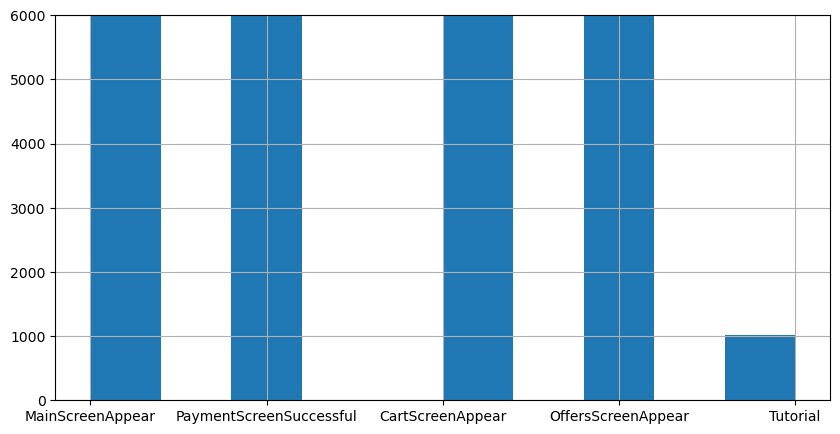

In [19]:
# посмотрим на графике распределение типов событий
plt.figure(figsize=(10, 5))
df['name'].hist(bins=10)
plt.ylim(0, 6000)
plt.show()

Согласно графику, тип события Tutorial встречается сильно реже остальных (порядка 1000 раз).

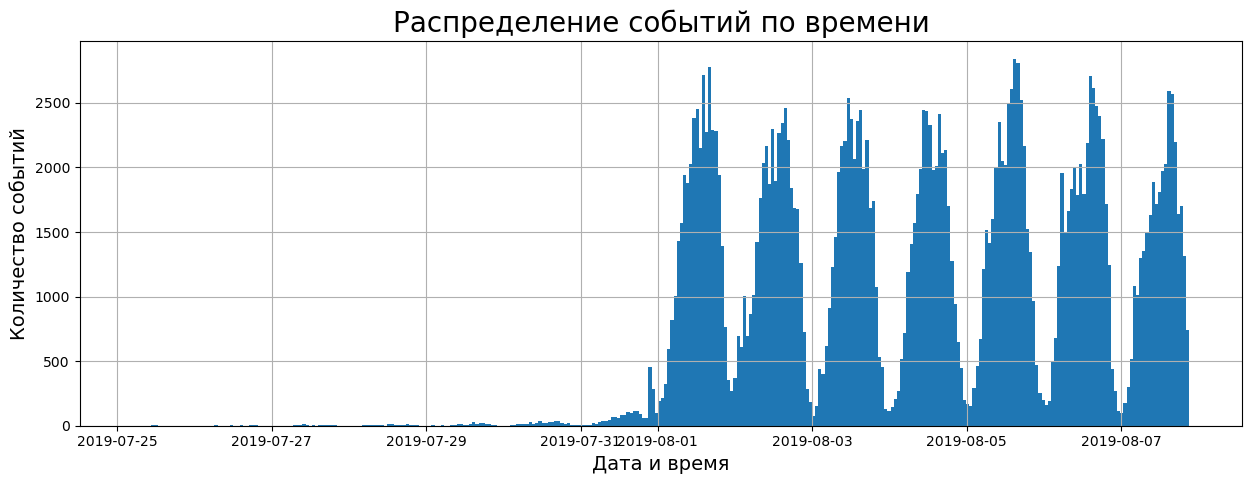

In [20]:
plt.figure(figsize=(15, 5))
df['time'].hist(bins=14*24)
plt.title('Распределение событий по времени', fontsize= 20)
plt.ylabel("Количество событий", fontsize=14)
plt.xlabel("Дата и время", fontsize=14)
plt.show()

In [21]:
# удадлим данные до 31 июля с помощью среза
df1 = df[df['time']>'2019-08-01 00:00:00']

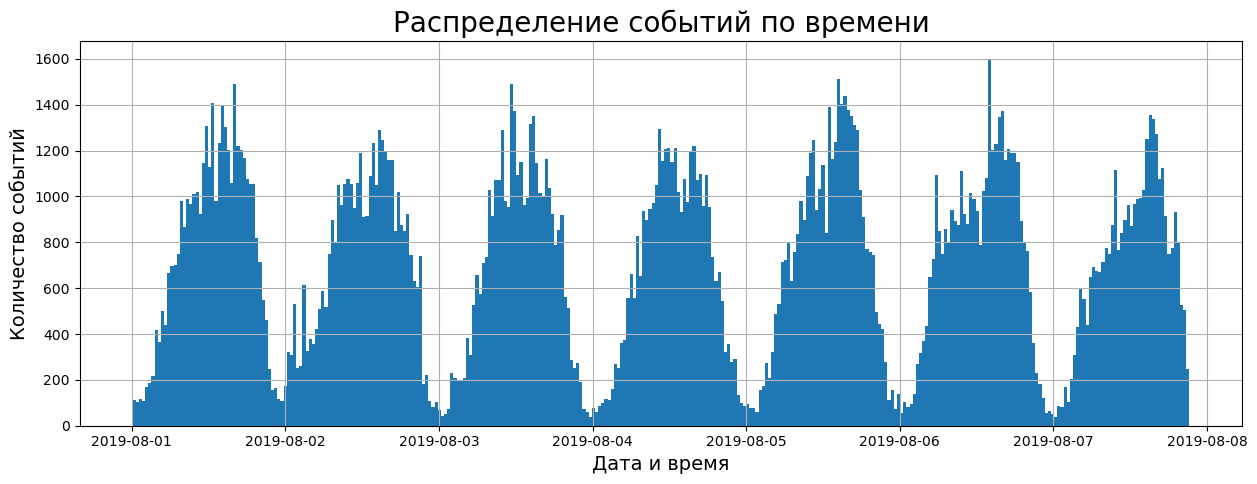

In [22]:
# проверка
plt.figure(figsize=(15, 5))
df1['time'].hist(bins=14*24)
plt.title('Распределение событий по времени', fontsize= 20)
plt.ylabel("Количество событий", fontsize=14)
plt.xlabel("Дата и время", fontsize=14)
plt.show()

In [23]:
# посчитаем после среза количество пользователей и событий
print(df1['name'].count())
df1['id'].nunique()

240887


7534

In [24]:
# посчитаем относительные показатели различия, объявим переменные с неотфильтрованными и отфильтрованными данными                         
events = len(df)
users = df['id'].nunique()
events_filtered = len(df1)
users_filtered = df1['id'].nunique()

In [25]:
# посчитаем процент, округлив до 2 значений после запятой
percentage_events = round(100-events_filtered/events*100, 2)
print(percentage_events)
percentage_users = round(100-users_filtered/users*100, 2)
print(percentage_users)

1.16
0.23


In [26]:
# посчитаем среднее количество событий на пользователя
mean_event_id = round(df['name'].count()/df['id'].nunique(), 1)
mean_event_id 

32.3

In [27]:
# проверим число пользователей по трем экспериментальным группам
# всего пользователей по группам
count_event = df1.groupby(['group'])['id'].count().sort_values(ascending=False).reset_index()
count_event

,group,id
0,248,84563
1,246,79302
2,247,77022


In [28]:
# всего уникальных пользователей
users_count = df1.groupby('group').agg({'id': 'nunique'}).sort_values(by='id', ascending=False).reset_index()
users_count

,group,id
0,248,2537
1,247,2513
2,246,2484


В ходе исследовательского анализа было посчитано количество событий и пользователей (примерно 244 тыс и 7.6 тыс), а также среднее количество событий на пользователя (32). Кроме того, были рассчитаны максимальная и минимальная даты исследуемого периода - с 25 июля по 7 августа 2019 года, то есть 2 недели, на первый взгляд. Однако, после построения гистограммы по дате и времени можно увидеть, что только приблизительно с 1 августа начинаются события, поэтому следует отбросить ненужные данные (то есть до 31 июля). Таким образом, мы располагаем для последующего анализа следующим временным периодом: с 1 августа по 7 августа 2019 года.
<br>

После среза исходных данных, количество пользователей (было удалено всего 9) и событий (796 или 0.3%) не сильно сократилось, среднее число событий на пользователя не изменилось.
<br>

По всем трем экспериментальным группам количество пользователей (общее и уникальных) примерно одинаковое.

## Анализ воронки событий

In [29]:
# количество различных событий 
events_count = df1.groupby('name').agg({'id': 'nunique'}).sort_values(by='id', ascending=False).reset_index()
events_count.columns = ['name', 'count_users']
events_count

,name,count_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [30]:
# количество пользователей по событиям
users_count = df1.groupby('name').agg({'id': 'count'}).sort_values(by='id', ascending=False).reset_index()
users_count.columns = ['name', 'count_id']
users_count

,name,count_id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [31]:
# доля пользователей, которые хоть раз совершали заказа, поделим количество событий на общее число уникальных пользователей
events_count['share_user']= round(events_count['count_users']/7542*100, 1)
events_count

,name,count_users,share_user
0,MainScreenAppear,7419,98.4
1,OffersScreenAppear,4593,60.9
2,CartScreenAppear,3734,49.5
3,PaymentScreenSuccessful,3539,46.9
4,Tutorial,840,11.1


По частоте событий - самым частотным является открытие главной страницы (MainScreenAppear), далее открытие страницы товаров (OffersScreenAppear), потом открытие страницы с корзиной (CartScreenAppear), далее открытие страницы с успешной оплатой и в конце - страницы с обучением (Tutorial). Предположительно в такой последовательности и происходит события в приложении.

Согласно доле пользователей, совершивших хоть раз событие, порядка 99% открывали главную страницу, 61% - страницу товаров, около 50% - страниу с корзиной, чуть меньше - 47% - страницу успешной оплаты заказа и только 11% - обучающую страницу.

**Воронка событий**: конверсия "в шаг" и общая конверсия

In [32]:
# доля пользователей, проходящая на следующий шаг (конверсия "в шаг")
events_count['step_conversion_funnel'] =  round(events_count['count_users'] / events_count['count_users'].shift() * 100, 1)
events_count['step_conversion_funnel'] = events_count['step_conversion_funnel'].fillna('100')
events_count[:-1]

,name,count_users,share_user,step_conversion_funnel
0,MainScreenAppear,7419,98.4,100
1,OffersScreenAppear,4593,60.9,61.9
2,CartScreenAppear,3734,49.5,81.3
3,PaymentScreenSuccessful,3539,46.9,94.8


In [33]:
# доля пользователей, доходящая от первого события до последнего (общая конверсия)
events_count['conversion_funnel'] = round(events_count['count_users'] / events_count['count_users'][0] * 100, 1)
events_count

,name,count_users,share_user,step_conversion_funnel,conversion_funnel
0,MainScreenAppear,7419,98.4,100,100.0
1,OffersScreenAppear,4593,60.9,61.9,61.9
2,CartScreenAppear,3734,49.5,81.3,50.3
3,PaymentScreenSuccessful,3539,46.9,94.8,47.7
4,Tutorial,840,11.1,23.7,11.3


Анализ воронки показал, что самая большая конверсия в шаг происходит с перехода со страницу корзины на страницу успешной оплаты (примерно 95%), также большая конверсия пользователей, перешедших со страницы товаров на страницу корзины (81%). Самая низкая конверсия у обучающей страницы - на нее перешло только порядка 24%, а также на страницу заказа (62%).
<br>

По общей конверсии, доля пользователей, перешедших от первого события до оплаты, составляет порядка 48%, то есть практически половина, открывших главную страницу приложения, сделали заказ. Можно предположить, основываясь на обеих конверсиях, что определенная проблема существует при переходе с главной страницы на страницу с товарами, и можно предположить, что, если пользователь попадет на страницу корзины, большая вероятность, что он завершит заказ покупкой. 

## Анализ А/А/В теста

Для проведения А/А/В теста мы исключим событие Tutorial из анализа, так как оно не имеет отношение к конверсии.

In [34]:
# исключаем событие Tutorial
df1 = df1.query('name != "Tutorial"')
# проверяем 
df1['name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: name, dtype: int64

In [35]:
# количество пользователей в группах
groups_count = df1.groupby('group').agg({'id': 'nunique'}).sort_values(by='id', ascending=False)
groups_count

,id
group,
248,2535
247,2512
246,2483


В экспериментальной группе - 2540 человек, и в контрольных группах  - 2517 и 2485 человек. В целом приблизительно выборки равны между собой.

**А/А тест**

In [36]:
# проверим разницу между контрольными группами 246 и 247
group_246 = df1.query('group==246').groupby('group')['id'].nunique().reset_index()
group_247 = df1.query('group==247').groupby('group')['id'].nunique().reset_index()
inequality = round((group_246.loc[0][1]/group_247.loc[0][1]*100)-100, 1)
inequality

-1.2

Разница между группами не более 1.3%, то есть различие в целом не большое, чуть превышает 1%, что может свидетельствовать об успешности А/А теста. 

Найдем самое популярное событие по группам

In [37]:
# создадим сводную таблицу по событиям и количеству пользователей из групп 246 и 247
aa = df1.query('group != 248')
df1_aa = aa.pivot_table(index='group', values='id', columns='name', aggfunc='nunique')
df1_aa

name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
group,,,,
246,1266,2450,1542,1200
247,1238,2476,1520,1158


Самое популярное cобытие в обеих группах - открытие главной страницы приложения (MainScreenAppear).

Проверка гипотезы о равенстве долей с помощью Z-критерия

In [38]:
# напишем функцию
alpha = 0.05 
def z_test (successes1, successes2, trials1, trials2):
   
    # пропорция успехов в первой группе:
    p1 = successes1/trials1

    # пропорция успехов во второй группе:
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    return p_value

In [39]:
for i in range(0, 4):
        p_value = z_test(df1_aa.loc[246, df1_aa.columns[i]], df1_aa.loc[247, df1_aa.columns[i]], groups_count.loc[246], groups_count.loc[247])
        print('p-значение: ', p_value)

        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

p-значение:  [0.22867644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.75267034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.24786097]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Тест проведен корректно - статистически значимых различий между двумя А-группами не обнаружено.

**AА/B тест**: между выборками 246 и 248, 247 и 248, объединенной группой 246+247 и 248 

In [40]:
# сводная таблица по событиям и количеству пользователей во всех группах
ab_piv = df.pivot_table(index='group', values='id', columns='name', aggfunc='nunique')
ab_piv 

name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
group,,,,,
246,1270,2456,1545,1202,279
247,1240,2482,1530,1160,286
248,1239,2501,1538,1185,282


In [41]:
# между группами 246 и 248
for i in range(0, 4):
        p_value = z_test(ab_piv.loc[246 , ab_piv.columns[i]], ab_piv.loc[248, ab_piv.columns[i]], groups_count.loc[246], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")   

p-значение:  [0.10752984]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.41200621]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.25861854]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.23807776]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [42]:
# между групп 247 и 248
for i in range(0, 4):
        p_value = z_test(ab_piv.loc[247 , ab_piv.columns[i]], ab_piv.loc[248, ab_piv.columns[i]], groups_count.loc[247], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")     

p-значение:  [0.7291536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.64084703]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.86308114]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.68623315]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [43]:
# объединим группы 246 и 247 в группу А
aab_piv = df1.pivot_table(index='group', values='id', columns='name', aggfunc='nunique')
aab_piv.index=['A','A','B']
aab_piv = aab_piv.reset_index().groupby('index').sum()
aab_piv

name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
index,,,,
A,2504,4926,3062,2358
B,1230,2493,1531,1181


In [44]:
# между объединенной группой и 248
for i in range(0, 4):
        p_value = z_test(aab_piv.loc['A', aab_piv.columns[i]], aab_piv.loc['B', aab_piv.columns[i]], groups_count.loc[246]+groups_count.loc[247], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  [0.18683559]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.34866843]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.44582745]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.61079187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимых различий при сравненении экспериментальной и контрольных групп (как по отдельности, так и в комбинированной группе (246+247) не обнаружилось.

**Проверка при уровне значимости 0.1**

In [45]:
# между группами 246 и 247
alpha = 0.1 
for i in range(0, 4):
        p_value = z_test(df1_aa.loc[246, df1_aa.columns[i]], df1_aa.loc[247, df1_aa.columns[i]], groups_count.loc[246], groups_count.loc[247])
        print('p-значение: ', p_value)

        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

# для групп 246 и 248
for i in range(0, 4):
        p_value = z_test(ab_piv.loc[246 , ab_piv.columns[i]], ab_piv.loc[248, ab_piv.columns[i]], groups_count.loc[246], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")  
            
# для групп 247 и 248
for i in range(0, 4):
        p_value = z_test(ab_piv.loc[247 , ab_piv.columns[i]], ab_piv.loc[248, ab_piv.columns[i]], groups_count.loc[247], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 
                      
# для групп 246+247 и 248            
for i in range(0, 4):
        p_value = z_test(aab_piv.loc['A', aab_piv.columns[i]], aab_piv.loc['B', aab_piv.columns[i]], groups_count.loc[246]+groups_count.loc[247], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  [0.22867644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.75267034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.24786097]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.10752984]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.41200621]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.25861854]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.23807776]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.7291536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.64084703]
Не получилось отвергнуть нулевую гипоте

При уровне значимости 0.1 не поменялись результаты АА/В тестов: в группах нет статистически значимых различий. Значит, изменение шрифта в приложении не влияет на конверсию пользователей.

Нами было проведено 16 тестов (4 сравнения по группам (А1 и А2, А1+А2 и В, А1 и Вб А2 и В) по 4 шагам воронки), то есть тесты множественные. При проведении подобных тестов возрастает вероятность ошибки - получения ложноположительного результата, когда нет статистически значимых различий, поскольку при множественном тесте p_value стремится к 1. Чтобы устранить эту проблему, можно воспользовать поправкой Бонферрони, поделив уровень значимости на число проводимых тестов. В целом данный метод считается достаточно грубым при большом количестве тестов, но в нашем случае тестов было не очень много (16), поэтому применение этого метода представляется целесообразным.

In [46]:
# между группами 246 и 247
alpha = 0.5/16 
for i in range(0, 4):
        p_value = z_test(df1_aa.loc[246, df1_aa.columns[i]], df1_aa.loc[247, df1_aa.columns[i]], groups_count.loc[246], groups_count.loc[247])
        print('p-значение: ', p_value)

        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

# для групп 246 и 248
for i in range(0, 4):
        p_value = z_test(ab_piv.loc[246 , ab_piv.columns[i]], ab_piv.loc[248, ab_piv.columns[i]], groups_count.loc[246], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")  
            
# для групп 247 и 248
for i in range(0, 4):
        p_value = z_test(ab_piv.loc[247 , ab_piv.columns[i]], ab_piv.loc[248, ab_piv.columns[i]], groups_count.loc[247], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")    
                      
# для групп 246+247 и 248            
for i in range(0, 4):
        p_value = z_test(aab_piv.loc['A', aab_piv.columns[i]], aab_piv.loc['B', aab_piv.columns[i]], groups_count.loc[246]+groups_count.loc[247], groups_count.loc[248])
        print('p-значение: ', p_value)
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
                      

p-значение:  [0.22867644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.75267034]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.24786097]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.11446628]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.10752984]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.41200621]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.25861854]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.23807776]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.7291536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.64084703]
Не получилось отвергнуть нулевую гипоте

При использовании уровня значимости 0.05 тесты не обнаружили статистически значимых различий и естественно, что при применении поправки Бонферрони они также не обнаружились, т.к. данная поправка еще больше снижает вероятность их нахождения. Таким образом, наиболее оптимальным уровнем значимости можно считать 0.05.

## **Общие выводы** ##

В ходе исследовательского анализа был уточнен временной период анализа - с 1 августа по 7 августа 2019 года. Все три группы, анализируемые в А/А/В тесте имеют примерно одинаковое количество событий и пользователей. 
<br>

По частоте событий - самым частотным является открытие главной страницы (MainScreenAppear), далее открытие страницы товаров (OffersScreenAppear), потом открытие страницы с корзиной (CartScreenAppear), далее открытие страницы с успешной оплатой и в конце - страницы с обучением (Tutorial). 
Согласно доле пользователей, совершивших хоть раз событие, порядка 99% открывали главную страницу, 61% - страницу товаров, около 50% - страницу с корзиной, чуть меньше - 47% - страницу успешной оплаты заказа и только 11% - обучающую страницу.
<br>

Анализ воронки показал, что самая большая конверсия в шаг происходит с перехода со страницу корзины на страницу успешной оплаты (примерно 95%), также большая конверсия пользователей, перешедших со страницы товаров на страницу корзины (81%). Самая низкая конверсия у обучающей страницы - на нее перешло только порядка 24%, а также на страницу заказа (62%).
По общей конверсии, доля пользователей, перешедших от первого события до оплаты, составляет порядка 48%, то есть практически половина, открывших главную страницу приложения, сделали заказ. Можно предположить, основываясь на обеих конверсиях, что определенная проблема существует при переходе с главной страницы на страницу с товарами, и можно предположить, что, если пользователь попадет на страницу корзины, большая вероятность, что он завершит заказ покупкой.
<br>

Согласно проведенному А/А тесту, не обнаружено различий в долях в двух контрольных группах, значит, все расчеты корректны, А/А тест прошел успешно, можно проводить А/А/В тест.

<br>
А/А/В тест не позволил обнаружить статистически значимые различия в группах, как при уровне значимости 0.05, так и после применения поправки Бонферрони. Значит, изменение шрифта в приложении не влияет на конверсию пользователей, таким образом, не следует менять шрифт с целью увеличения конверсии пользователей данного мобильного приложения.